In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We import all the main important **dependencies** 

In [ ]:
import random, os
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imutils import paths
from sklearn.model_selection import train_test_split
import pickle
import shutil
from keras import backend as K



def tf_seed(seed=0):
  np.random.seed(seed)  # numpy seed
  tf.random.set_seed(seed)  # tensorflow seed
  random.seed(seed)  # random seed
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)
  


tf_seed()

#see https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

The main idea is to classify a **bonafide or attack** human face with a fast **CNN**, setting on the top of the network an **SSD** model, pretrained on a **ResNet**, that can extract faces from images.

The network will have two main convolutional steps, in which we are going to extract deep features from the second phase. It uses in sequence **Conv2d + BatchNormalization** to learn faster, normalizing batch feature maps to avoid **overfitting**. However, this is why is important to set a right batch size and training data to avoid the opposite problem, then underfitting. The BatchNormalization, since this is a shallow network, won't have the so called vanishing gradient problem during the first training epochs.

There are also, at the end of each phase, a Dropout layer. This is because it's important to learn as much details as possible to distinguish a "real or fake" person in front of a camera. So switching off weights during training randomly, will have the consequence to distribute better the learning of important features among all the weights.

# DEFINE NETWORK

## Originary Network

In [ ]:
def LiveNet(input_size):

  chan_dim=-1 #feature map channel

  #first convolutional phase
  input = tf.keras.layers.Input(input_size)
  x = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #second convolutional phase
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
  x = tf.keras.layers.BatchNormalization( axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(x)

  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #dense phase
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(64, activation = 'relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)


  x = tf.keras.layers.Dropout(0.5)(x)  #to avoid overfitting 
  #softmax 
  output = tf.keras.layers.Dense(2, activation = 'softmax')(x)
 
  return tf.keras.models.Model(input, output)

## AttackNet v2.2

In [ ]:
def LiveNet(input_size):

  chan_dim=-1 #feature map channel

  #first convolutional phase
  input = tf.keras.layers.Input(input_size)
  y = tf.keras.layers.Conv2D(16, 3, padding = 'same')(input)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  x = tf.keras.layers.Conv2D(16, 3, padding = 'same')(x)
  z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  x = tf.keras.layers.add([y,z])
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #second convolutional phase
  y = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
  x = tf.keras.layers.LeakyReLU(alpha=0.2)(y)
  x = tf.keras.layers.BatchNormalization( axis=chan_dim)(x)
  x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
  x = tf.keras.layers.Conv2D(32, 3, padding = 'same')(x)
  z = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
  x = tf.keras.layers.add([y,z])
  x = tf.keras.layers.BatchNormalization(axis=chan_dim)(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = tf.keras.layers.Dropout(0.25)(x)

  #dense phase
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation = 'tanh')(x)
  #x = BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  #softmax 
  output = tf.keras.layers.Dense(2, activation = 'softmax')(x)
 
  return tf.keras.models.Model(input, output)

# 3DMAD DATASET

The dataset is the following: https://www.idiap.ch/en/dataset/3dmad/index_html

Nesli Erdogmus and Sébastien Marcel, "Spoofing in 2D Face Recognition with 3D Masks and Anti-spoofing with Kinect", Biometrics: Theory, Applications and Systems, 2013.
10.1109/BTAS.2013.6712688
https://publications.idiap.ch/index.php/publications/show/2657

<br>The 3D Mask Attack Database (3DMAD) is a biometric (face) spoofing database. We get a subset of data. In our case it contains frames of 17 persons, recorded using Kinect for both real-access and spoofing attacks. Each frame consists of:

*   a depth image (640x480 pixels – 1x11 bits)
*   the corresponding RGB image (640x480 pixels – 3x8 bits)

<br>The data is collected in **3 different sessions** for all subjects and for each session 5 videos of 300 frames are captured. The recordings are done under controlled conditions, with frontal-view and neutral expression. The first two sessions are dedicated to the real access samples, in which subjects are recorded with a time delay of ~2 weeks between the acquisitions. In the third session, 3D mask attacks are captured by a single operator (attacker).

 


## Training and Validation Data

We define **which subject folders** to use in **a certain session** for **validation data**. **Training data** will be equal to the remaining data.

Setting the variable **split_randomly_training_and_validation**
to **true** will **ignore** validation chosen data, and **will split the entire dataset in 70% for training, 30% for validation. It is not recommended, but you can check how easy is to reach a good validation accuracy, since there are subjects for testing that appear also on training**.

## Define Root Folders

In [ ]:
root_folder="/content/drive/MyDrive/liveness_project/"


protoPath=os.path.join(root_folder,'face_detector/deploy.prototxt.txt')
modelPath = os.path.join(root_folder,
	"face_detector/res10_300x300_ssd_iter_140000.caffemodel")


face_confidence=0.68

root_3DMAD_extracted=os.path.join(root_folder,'dataset/training/3DMAD extracted/')

all_bonifade_folders=[1,2] #session 1,2
all_attack_folders=[3] #session 3

# here for training we use all the folders except that used for validation
attack_validation_labels=[[3,[7, 10,11,12,13,14]]] #from session 3, take subjects n. 10,11,12,13,14 folders for attack validation
bonifade_validation_labels=[[1,[7, 10,11,12,13,14]],[2,[7, 10,11,12,13,14]]] #from session 1 and 2, take subjects n. 10,11,12,13,14 folders for bonifade validation

split_randomly_training_and_validation=False

#will ignore validation data since all dataset will be splitted in 70% for training and 30% for validation
if split_randomly_training_and_validation:
	attack_validation_labels=[]
	bonifade_validation_labels=[]



#we define where to save output detected faces and the corresponding depth
output_attack_training_folder=os.path.join(root_folder,'dataset/training/3DMAD/images/attack_training/')
output_attack_validation_folder=os.path.join(root_folder,'dataset/training/3DMAD/images/attack_validation/')

output_bonifade_training_folder=os.path.join(root_folder,'dataset/training/3DMAD/images/bonifade_training/')
output_bonifade_validation_folder=os.path.join(root_folder,'dataset/training/3DMAD/images/bonifade_validation/')


save_augmented_images =  os.path.join(root_folder,'dataset/training/3DMAD/augmented_images/') #output of online augmented images 
save_model_h5 = os.path.join(root_folder,'model_3DMAD.h5') 
save_labels = os.path.join(root_folder,'model_3DMAD_labels')
save_training_metrics_plot = os.path.join(root_folder,'3DMAD_plot.png')

output_np_training_array = os.path.join(root_folder,'3DMAD_training_array')



def check_subject_folder(subjects, folder_name):

	for subject in subjects:
		if int(folder_name.split("_")[0]) == subject:
			return True

	return False

#is_validation needs to understand if we are taking folders for validation or training
#validation_folders needs when we are taking data for training: we get all the folders - validation folders in this case
def get_folders(is_validation=True, labels=None, validation_folders=None):
	folders=[]
	new_directories=[]

	if is_validation:

		for label in labels:
			new_root = os.path.join(root_3DMAD_extracted,"session " + (str(label[0]) ))
	 
			subjects = label[1]

			new_directories += [f.path for f in os.scandir(new_root) if f.is_dir() and check_subject_folder(subjects, f.name)]

	else:
		#for training we use all the session folders - validation folders
		for label in labels:
			new_root = os.path.join(root_3DMAD_extracted,"session " + str(label))
	 
			new_directories += [f.path for f in os.scandir(new_root) if f.is_dir()]
			new_directories = list(set(new_directories) - set(validation_folders))	#exclude subjects used for testing
		 

				
	for directory in new_directories:
				sublist=[]
				sublist.append(os.path.join(directory, "Color_Data"))
				sublist.append(os.path.join(directory, "Depth_Data"))
				folders.append(sublist)
		

	
	if is_validation:
			return folders, new_directories
	
	return folders


attack_folders_validation, attack_validation_folders=get_folders(labels=attack_validation_labels)
attack_folders_training = get_folders(labels=all_attack_folders, is_validation=False, validation_folders=attack_validation_folders)


bonifade_folders_validation, bonifade_validation_folders=get_folders(labels=bonifade_validation_labels)
bonifade_folders_training = get_folders(labels=all_bonifade_folders, is_validation=False, validation_folders=bonifade_validation_folders)


training_directories=[attack_folders_training, attack_folders_validation, bonifade_folders_training, bonifade_folders_validation]
output_directories=[output_attack_training_folder, output_attack_validation_folder, output_bonifade_training_folder, output_bonifade_validation_folder]


#create directories where to save images if they don't exist
for output_dir in output_directories:
	if not os.path.exists(output_dir): 
	  os.makedirs(output_dir)
	  print("created ", output_dir)
	 
	mask_dir = os.path.join(output_dir ,"mask")
	if not os.path.exists(mask_dir): 
	  os.makedirs(mask_dir)
	 
print("Attack folders for validation: " , attack_folders_validation)
print("Attack folders for training: " , attack_folders_training)

print("Bonifade folders for validation: " , bonifade_folders_validation)
print("Bonifade folders for training: " , bonifade_folders_training)



Attack folders for validation:  [['/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/13_03_05/Color_Data', '/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/13_03_05/Depth_Data'], ['/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/14_03_01/Color_Data', '/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/14_03_01/Depth_Data'], ['/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/07_03_04/Color_Data', '/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/07_03_04/Depth_Data'], ['/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/10_03_02/Color_Data', '/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/10_03_02/Depth_Data'], ['/content/drive/MyDrive/liveness_project/dataset/training/3DMAD extracted/session 3/11_03_03/Color_Data', '/co

# NETWORK PARAMETERS FOR TRAINING

In [ ]:
final_x = 32
final_y = 32

n_channels = 3

dim = (final_x, final_y)

epochs=20
batch_size=16
init_learning_rate= 1e-5

#return normalized image
def resize_normalize_image(image, value=255):
  image=cv2.resize(image, dim)
  return (image)/value

# FACE PROCESSING

## Network to Detect Faces

We define the SSD network that detects face inside an image.

In this case, since depth mask is not aligned with the original rgb image, we need to take the aligned color to depth image for each color image, in this way we can then concatenate the depth to the rgb channels.

In [ ]:


net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

def im_show(image, size=(15,15), output=None):
   fig = plt.figure(figsize=size) # set the height and width in inches
   plt.imshow(image, cmap="Greys", interpolation="nearest")
   plt.axis("off")
   plt.show()

   if output is not None:
     cv2.imwrite(output, image)

# detect the most probable face, or all of detected face
# return coordinates of bounding box for each face and the face itself as a cv2 object
def detect_save_face(color, depth, output_path=None, mask_output=None, multiple_output=False):

    (h, w) = color.shape[:2] 


    # we preprocess image normalizing each r-g-b channel subtracting the values in the last tuple
    blob = cv2.dnn.blobFromImage(cv2.resize(color, (300, 300)), 1.0,
                                 (300, 300), (104.0, 177.0, 123.0))
    

    # pass the blob through the network and obtain the detections and
    # predictions
    net.setInput(blob)
    detections = net.forward()


    faces = []
    coordinates=[]


    # ensure at least one face was found
    if  len(detections) > 0:

    
        max_i=np.argmax(detections[0, 0, :, 2]) #this is the most probable detected face

        #if we want to output the most probable detected face or all the faces
        min_range = 0 if multiple_output==True else max_i 
        max_range = detections.shape[2] if multiple_output==True else max_i + 1

        for i in range(min_range, max_range):

             # we get the model confidence
              confidence = detections[0, 0, i, 2]

              if confidence >= face_confidence:
               
                # compute the (x, y)-coordinates of the bounding box for
                # the face and extract the face ROI
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

               
                # we save coordinates 
                coordinates.append(box.astype("int"))
                face = color[startY:endY, startX:endX]
                face_mask = depth[startY:endY, startX:endX]

                

                #we save the face
                faces.append(face)

                              
                if mask_output is not None:
                     np.save(mask_output, face_mask)
      
                if output_path is not None:
                    cv2.imwrite(output_path, face)
                    
             

    return faces, coordinates


#return file name given a path
def get_file_name(path):
    base = os.path.basename(path)
    return os.path.splitext(base)[0]

#return file extension given a path
def get_file_type(path): 
    base = os.path.basename(path)
    return os.path.splitext(base)[1] # ex. .png, .jpg

print(get_file_type("file.png"))



.png


## Extract Faces from Images

We are going to take videos or images from our dataset. For each frame will be detected **one** face, and this one will be saved to the output folders defined before. The code reserves the possibility for the user to define also a mask for each image. In this case, the detected face will be also "cropped" from the mask.

In [ ]:

max_images_per_folder=200000 #we want to take a maximum number of images for training since limited hardware resources


#for each training input directory, search for color image
#for each color image (RGB), we take the corresponding align_to_depth and depth images 
#for each image and depth, we detect one face
def take_images():
    directory_counter = 0
    file_counter = 0

    for main_list in training_directories:

          folder_file_counter=0

          d_index=0

          print("we're on array %d/%d" % (directory_counter + 1, len(training_directories)))


          for directory in main_list:

            d_index+=1

          # files = [file for file in os.listdir(directory[0])]

            list_images = list(paths.list_images(directory[0]))

            print("found %d images for folder n. %d/%d" % (len(list_images), d_index, len(main_list)))


            #we shuffle training data since we just take a limited number of images
            random.Random(20).shuffle(list_images)


            for file_path in list_images:

                if folder_file_counter > max_images_per_folder:
                  break

              #  file_path = os.path.join(directory, file)
                
                file_name=get_file_name(file_path)
                try:
                  depth_image=np.load(os.path.join(directory[1], file_name + ".npy"))
                except:
                  continue
                
                color=cv2.imread(file_path)

              

                detect_save_face(color, depth_image, (output_directories[directory_counter] + "%s%s" % (
                        "frame_%d" % file_counter, get_file_type(file_path))), (output_directories[directory_counter] + "/mask/%s%s" % (
                        "frame_%d_mask" % file_counter, ".npy")))
                    
                folder_file_counter+=1

                print("save face detected on image n. %d, for folder n. %d" % (file_counter, directory_counter + 1))


                file_counter += 1

          directory_counter += 1


take_images() 


# TRAINING SECTION

## Get Training and Validation Data

For each directory where we saved detected faces, we are going to create two arrays: images, that will be concatenated with the depth mask, **by default**, and labels (0 for bonafide, 1 for attackers)


In [ ]:

def get_images(directories, mask=True, balance_dataset=True, undersampling=False):

    image_list = []
    label_list = []

    classes = 0

    images_per_class=[]

    tf_seed()

    #for each input directory
    for i in directories:

        list_images = [f for f in os.listdir(i) if os.path.isfile(os.path.join(i, f))]

        images_number = len(list_images)

        random.Random(20).shuffle(list_images)

        print("n %d" % images_number)

        #if we use undersampling
        if undersampling:
          images_number = images_number if ((len(images_per_class) == 0) or (images_number <= images_per_class[-1]))  else images_per_class[-1]
        
        
        # to fill tensors we inizialise them
        X = np.empty((images_number, final_x, final_y, n_channels))

        L = np.empty((images_number))

        ipp = 0

        for im_name in list_images:
            
            im=os.path.join(i, im_name)


            # to get "balanced dataset" using undersampling method
            if (balance_dataset and undersampling) and len(images_per_class)  and ipp == images_per_class[-1]:
                break

            image = cv2.imread(im)

        

            image=resize_normalize_image(image, value=255)

          
            if mask:
              mask_name = os.path.join(
                    i,"mask", get_file_name(im) + "_mask.npy")
              image_mask = np.load(mask_name)
              image_mask = resize_normalize_image(image_mask, value=2048)  #since 3DMAD mask is rgb 2^11
              
                        

            X[ipp, ..., :3] = image # each original image is rgb
            
            if mask:
              X[ipp,...,3] = image_mask # each mask can be n_channels - 3

            L[ipp] = classes  # 0 for real, 1 for fake for binary classification

            ipp += 1
        
        # check if the current class has lower images than the before
        # in this case we undersample the majority class randomly removing elements
        # we will have a balanced dataset: same images for all the classes

        if balance_dataset and undersampling:
            if len(images_per_class) and ipp < images_per_class[-1]:
            
              left_shift = 0

              for i in range(0, len(images_per_class)):

                  diff = images_per_class[i] - ipp

                  for j in range(0, diff):
                      random_index = np.random.randint(left_shift, images_per_class[i] - j)
                      image_list.pop(random_index)
                      label_list.pop(random_index)

                  left_shift += images_per_class[i] - diff

        if undersampling or balance_dataset==False:
              for image in X:
                image_list.append(image)

              for label in L:
                label_list.append(label)
        else:
              image_array=[]
              label_array=[]
            
              for image in X:
                image_array.append(image)

              image_list.append(np.array(image_array, dtype="float"))

             
              for label in L:
                label_array.append(label)

              label_list.append(label_array)

              #[[2k], [1k]]
        
        if undersampling or balance_dataset==False:
            images_per_class.append(ipp)
        else:
            images_per_class.append(images_number)

        classes += 1

    #offline augmentation
    if balance_dataset and undersampling==False:

      
         max=np.max((images_per_class)) #[4k,3k,2k,1k]

         for j in range(0, len(images_per_class)):  #[[4k], [4k], [4k], [4k]]
            if images_per_class[j] < max:
              diff=max - images_per_class[j] #how many images to generate

              image_array=image_list[j]   #[3k]
              label_array=label_list[j]   #[3k]

              new_image_array=[]
             

              #use ImageDataGenerator 
              offline_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                       	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	                       horizontal_flip=True, fill_mode="constant")


              offline_generator=offline_generator.flow(image_array, batch_size=1, seed = 20)

              #generate the reamining images respect the majority class, to balance the dataset
              generated_images=0
              while generated_images < diff:
                     
                  for i in range(0,len(offline_generator)):
                        if generated_images == diff:
                          break
                        batch= next(offline_generator)
                        # print(batch.shape)
                        #print(new_image_array.shape)
                        new_image_array.append(batch[0])
                        
                        label_array.append(j)

                      
                        generated_images += 1

              print(generated_images)
     
              image_list[j]=np.append(image_list[j], new_image_array, axis=0)


         # image_list and label_list were of type [[...], [...]] for attack and bonafide classes
         # we need a final array of type [image1,image2,...] for images and [0,1,...] for labels

         new_image_list= np.empty((0, final_x, final_y, n_channels))
         new_label_list=[]


         for class_value_array in image_list:
           new_image_list = np.vstack((new_image_list,class_value_array))

         for class_value_array in label_list:
           new_label_list += class_value_array

         image_list = new_image_list
         label_list = new_label_list

         print(image_list.shape)
         print(len(label_list))
         
        # im_show(new_image_list[2]) # we can show up an image 
      
        
    #create the one-hot encoded vector: [0 1], [1 0]
    le = LabelEncoder()
    labels = le.fit_transform(label_list)
    labels = tf.keras.utils.to_categorical(labels, 2)

    if type(image_list) is np.ndarray:
      return image_list, labels, le

    return  np.array(image_list, dtype="float"), labels, le




read_from_np_array = True


## WE CAN SAVE NUMPY RESULTS AND REUSE THEM LATER ##

if read_from_np_array:
      (train_X, test_X, train_Y, test_Y) = pickle.loads(open(output_np_training_array, "rb").read())
      le = pickle.loads(open(save_labels, "rb").read())

## WE ARE GOING TO GET THE TRAIN AND VALIDATION DATASETS, AND WE SAVE THE NUMPY ARRAYS ##
else:
      
      train_X, train_Y, le = get_images([output_bonifade_training_folder, output_attack_training_folder], undersampling=True, mask = False)

     
      #will be ignored if we set split_randomly_training_and_validation variable to True
      test_X, test_Y, _ = get_images([output_bonifade_validation_folder, output_attack_validation_folder], undersampling=True, mask = False)


      #save model labels 
      f = open(save_labels, "wb")
      f.write(pickle.dumps(le))
      f.close()

      #save results
      pickle.dump((train_X, test_X, train_Y, test_Y), open(output_np_training_array, 'wb'))


#will split entire dataset in 80% for training and 30% for validation
if split_randomly_training_and_validation:

  #the random seed for splitting 
	split_seed=20

	trainX, testX, trainY, testY = train_test_split(train_X, train_Y,
	test_size=0.3, stratify=train_Y, seed=split_seed)
 
else:
	trainX, testX, trainY, testY = (train_X, test_X, train_Y, test_Y)
 
print("Shape training: ", trainX.shape)
print("Shape validation: ", testX.shape)


Shape training:  (1320, 32, 32, 3)
Shape validation:  (720, 32, 32, 3)


## Augmentation Online

In [ ]:
augmentation_online=True



#the random seed for online augmentation
generator_seed=10

 
if augmentation_online:
		#online augmentation of training images
		aug_training = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, zoom_range=0.25,
			width_shift_range=0.3, height_shift_range=0.3, shear_range=0.15,
			horizontal_flip=True, fill_mode="constant")


		#aug_training = tf.keras.preprocessing.image.ImageDataGenerator()


		# output an endless Iterator of batches
		# shuffle images, so the first generated batch is from batch_size random training images

		train_generator=aug_training.flow(trainX, trainY, batch_size=batch_size, shuffle=True, seed=generator_seed)


		# will be equal to np.ceil(len(train(X))/batch_size)
		# notice: if len(trainX) / batch_size is a float value, the last batch will contain less images than batch_size value
		print("lenght training batches ", len(train_generator))
		print("lenght training data ", len(trainX))
		print("lenght validation data ", len(testX))

		# we could use also a validation_generator, without augment images
		# this "trick" could be done for set up a valdation batch size on model.fit().. then at the end of an epoch, each batch will be validated

		#aug_validation=ImageDataGenerator()
		#validation_generator=aug_validation.flow(testX, testY, batch_size=batch_size, shuffle=False, seed=1)

lenght training batches  83
lenght training data  1320
lenght validation data  720


We can output the generator images organized in batches

In [ ]:

# we generate batch_size images, beginning from the first batch
batchx, batchy = next(train_generator)
for i in range(batchx.shape[0]):
    fig, (ax1) = plt.subplots(1) 
    ax1.set_title('image')  
    ax1.imshow(batchx[i][:,:,0], cmap='gray')
    print("Label-%d:"%i, batchy[i][0])


train_generator.reset() #once an epoch ends, this function will be called to reset data

# we generate exactly len(trainX) - batch_size images beginning from the first batch, since we have reset the train_generator on the line before
for i in range(0,len(train_generator) - 1):
 break # remove to see all training augmented images for an epoch
 batchx, batchy = next(train_generator)
 for i in range(batchx.shape[0]):
    fig, (ax1) = plt.subplots(1) 
    ax1.set_title('image')  
    ax1.imshow(batchx[i][:,:,0], cmap='gray')
    print("Label-%d:"%i, batchy[i][0])



## OFFLINE AUGMENTATION

For each image in the training set, we're going to augment the image itself and we add it to the training. So if we have 2k images for the training, the final length of the dataset will be 4k.

In [ ]:

augmentation_online=False

generator_seed=10
     

if not augmentation_online:


  to_augment=len(trainY) * 2

  #print(to_augment)
  # to fill tensors we inizialise them
  X = np.empty((to_augment, final_x, final_y, n_channels), dtype="float")

  L = np.empty((to_augment), dtype="int")

  #use ImageDataGenerator 
  offline_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=30, zoom_range=0.25,
			width_shift_range=0.3, height_shift_range=0.3, shear_range=0.15,
			horizontal_flip=True, fill_mode="constant")



  offline_generator=offline_generator.flow(trainX, trainY, shuffle=True, batch_size=1, seed=generator_seed)

  #for all initial images
  for i in range(0,to_augment):
            batchx, batchy = next(offline_generator)
            X[i] = batchx[0]
            L[i] = np.argmax(batchy[0])
          
  
  labels = le.fit_transform(L)
  labels = tf.keras.utils.to_categorical(labels, 2)

  trainX = np.vstack((trainX, X))
  trainY = np.vstack((trainY, labels))


print("Shape training: ", trainX.shape)
print("Shape validation: ", testX.shape)



Shape training:  (3960, 32, 32, 3)
Shape validation:  (720, 32, 32, 3)


## **Train the Model**

We train the **model** and we save in a **CustomCallback** instance the average loss and accuracy for each training and validation batch. In this way, we can create a more defined training plot.

[INFO] compiling model...
Using device for training: cuda
Epoch 1/20
83/83 [==============================] - 14s 21ms/step - loss: 1.1100 - accuracy: 0.4811 - val_loss: 0.7663 - val_accuracy: 0.4208
Epoch 2/20
83/83 [==============================] - 1s 17ms/step - loss: 0.9576 - accuracy: 0.5242 - val_loss: 0.7522 - val_accuracy: 0.4167
Epoch 3/20
83/83 [==============================] - 1s 17ms/step - loss: 0.9823 - accuracy: 0.5409 - val_loss: 0.7488 - val_accuracy: 0.5000
Epoch 4/20
83/83 [==============================] - 1s 17ms/step - loss: 0.9164 - accuracy: 0.5538 - val_loss: 0.7074 - val_accuracy: 0.5125
Epoch 5/20
83/83 [==============================] - 1s 17ms/step - loss: 0.8380 - accuracy: 0.5841 - val_loss: 0.5618 - val_accuracy: 0.6389
Epoch 6/20
83/83 [==============================] - 1s 17ms/step - loss: 0.8065 - accuracy: 0.5992 - val_loss: 0.4092 - val_accuracy: 0.7694
Epoch 7/20
83/83 [==============================] - 1s 17ms/step - loss: 0.7619 - accuracy: 0.6

<Figure size 432x288 with 0 Axes>

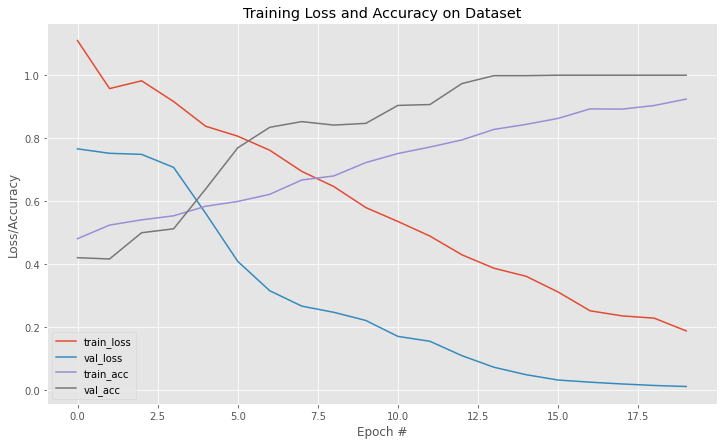

In [ ]:

import torch, psutil


class MemoryUsage(tf.keras.callbacks.Callback):

   def __init__(self):
      # setting device on GPU if available, else CPU
      self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
      print('Using device for training:', self.device)
      self.max_RAM=[]
      self.max_GPU=[]

   def get_memory_usage(self):
      gpu_dict = tf.config.experimental.get_memory_info('GPU:0')
      tf.print('\n GPU memory details [current: {} gb, peak: {} gb]'.format(
          float(gpu_dict['current']) / (1024 ** 3), 
          float(gpu_dict['peak']) / (1024 ** 3)))
   
   def get_size(self, byte, suffix="GB"):
    factor = 1024
    
    for unit in ["", "K", "M", "GB", "T", "P"]:
        if byte < factor:
            return f"{byte:.2f} GB"
        byte /= factor

   def on_train_end(self, epoch, logs=None):
      i=np.argmax(self.max_RAM)
      j=np.argmin(self.max_RAM)
      self.get_memory_usage()
      print("MAX RAM USAGE: %s / %s (%s)" % (self.get_size(self.max_RAM[i][0]), self.get_size(self.max_RAM[i][1]), str(self.max_RAM[i][2]) + "%" ))
      


   
   def on_epoch_end(self,epoch,logs=None):
      svmem = psutil.virtual_memory()
      self.max_RAM.append((svmem.active, svmem.total, svmem.percent))
      #self.get_memory_usage()
      
      
      
      


# initialize the optimizer and model
print("[INFO] compiling model...")




#opt = tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum = 0.5)
opt = tf.keras.optimizers.Adam(learning_rate=init_learning_rate)
#opt = tf.keras.optimizers.Adam(learning_rate=init_learning_rate)

#opt = tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum = 0.5)
#opt = tf.keras.optimizers.Adam(learning_rate=init_learning_rate, decay=init_learning_rate/epochs)


#opt = tf.keras.optimizers.SGD(learning_rate=init_learning_rate, momentum = 0.99)
tf_seed()
model = LiveNet((final_y,final_x,n_channels))

callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=False)
memory_usage = MemoryUsage()


model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])  # same of binary_crossentropy in this case



import time
start_time = time.time()

#validation batch_size is equal to batch_size in this case (32)
#check https://github.com/keras-team/keras/blob/v2.9.0/keras/engine/training.py#L1099-L1472
if augmentation_online:
    H=model.fit(
      train_generator, 
      validation_data = (testX, testY), 
      callbacks = [memory_usage, callback_early_stopping],
      epochs= epochs)
else:
   
   H=model.fit(
      trainX, trainY, 
      batch_size = batch_size,
      shuffle=True,
      validation_data = (testX, testY), 
      callbacks = [memory_usage, callback_early_stopping],
      epochs= epochs)

print("TRAINING TIME")
print("--- %s seconds ---" % (time.time() - start_time))

import matplotlib.pyplot as plt

#print((history.epoch_batch_train_acc[0])) #show first epoch batches averaged values

print("[INFO] serializing network to '{}'...".format(save_model_h5))
model.save(save_model_h5, save_format="h5")


if not read_from_np_array:
   #save model labels 
      f = open(save_labels, "wb")
      f.write(pickle.dumps(label_encoder))
      f.close()


plt.style.use("ggplot")
plt.figure()
fig=plt.figure(figsize=(12,7))



new_epochs=len(H.history['loss'])
plt.plot(np.arange(0, new_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, new_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, new_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, new_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


plt.savefig(save_training_metrics_plot)


# notice accuracy at the end of each epoch is the mean all over the batches, the same if we have more than 1 validation batch

#https://keras.io/guides/training_with_built_in_methods/
#https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss
#https://stackoverflow.com/questions/55097362/different-accuracy-by-fit-and-evaluate-in-keras-with-the-same-dataset

# the below code can give never seen images at each validation_step; more in general we divide validation dataset in batches
# see https://stackoverflow.com/questions/56991909/how-is-the-keras-accuracy-showed-in-progress-bar-calculated-from-which-inputs-i


#model.fit(train_generator,
 # steps_per_epoch=len(train_generator),
  #validation_data = validation_generator,
	#epochs=3)

## Evaluation

In [ ]:
#confusion matrix


from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
from itertools import cycle
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

model = tf.keras.models.load_model(save_model_h5)

y_score = model.predict(test_X)

y_pred = np.argmax(y_score, axis = 1)
y_test_ = np.argmax(test_Y, axis = 1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
  
    def precision(index):
      return round(cm[index][index] / cm[:, index].sum(),2)
    
    def recall(index):
      return round(cm[index][index] /cm[index].sum(),2)
    
    def F1_score(index):
      p=precision(index)
      r=recall(index)
      return round((2 * p * r)/(p + r),2)
    
    plt.figure(figsize=(6, 6), dpi=80)

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
   

    #### CREATE THE PRECISION / RECALL / F1_SCORE TABLE ####

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    fig, ax1 = plt.subplots(figsize=(10, 2 + 3 / 2.5))
    
    col_labels=["Bonafide", "Attacker"]
    row_labels=['Precision','Recall','F1 Score']
    row_func=[precision,recall,F1_score]
    table_vals=[]  

    row_colors = np.full(len(row_labels), 'linen')
    col_colors = np.full(len(col_labels), 'lavender')

    
    for i in range(0, len(row_labels)):

      row=[]

      for j in range(0, len(col_labels)):
         row.append(row_func[i](j))

      table_vals.append(row)
    

    # the rectangle is where I want to place the table
    table = plt.table(cellText=table_vals,
                  cellLoc='center',
                  rowColours=row_colors,
                  rowLabels=row_labels,
                  rowLoc='center',
                  colColours=col_colors,
                  colLabels=col_labels,
                  loc='center')
    table.scale(1, 2)
    ax1.axis('off')

class_names = ["Bonafide", "Attacker"]

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_, y_pred)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')


# we're using SoftMax
sigmoid=False

# if you use sigmoid as output, you can print one ROC Curve
if sigmoid:
    #ROC CURVE

    fpr, tpr, _ =  roc_curve(test_Y, y_score)
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=(5, 5), dpi=80)
    lw = 2

    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
